# ETH Trading strategy <span style="color:blue">using Transfer Learning</span>

In [1]:
# Enabling the notebook execution from this sub-folder
import sys, os, ipynbname
NOTEBOOK_NAME = f"{ipynbname.name()}.ipynb"
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(NOTEBOOK_NAME), os.path.pardir)))

In [2]:
# Importin utils global variables and methods
from src.Utils import *

Loading BokehJS ...

## Preliminary data import & First pre-processing steps

In [5]:
# Importing Ethereum pre-processed financial data
df = pq.read_pandas(source=f"{Utils.ASSETS_FOLDER}/parquet/{Utils.get_asset_id('Ethereum')}.parquet").to_pandas()

In [6]:
# Deepcopying the dataset
df_ = df.copy(deep=True)

In [8]:
# Displaying first rows
df.head()

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2018-01-01 00:01:00,173,738.3025,746.00,732.51,738.5075,335.987856,738.839291
2018-01-01 00:02:00,192,738.5075,745.14,732.49,738.2600,232.793141,738.268967
2018-01-01 00:03:00,120,738.3325,745.12,730.00,737.5025,174.138031,737.994457
2018-01-01 00:04:00,156,737.2225,744.69,728.93,737.1025,165.383926,737.303631
2018-01-01 00:05:00,118,736.5300,743.80,727.11,735.7050,193.078039,736.163026


In [9]:
# Displaying column informations
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2136196 entries, 2018-01-01 00:01:00 to 2022-01-24 00:00:00
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Count   int32  
 1   Open    float64
 2   High    float64
 3   Low     float64
 4   Close   float64
 5   Volume  float64
 6   VWAP    float64
dtypes: float64(6), int32(1)
memory usage: 122.2 MB


In [10]:
# Checking the types of the main DataFrame columns
df.dtypes

Count       int32
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
VWAP      float64
dtype: object

In [12]:
# Resampling to 30-min bins (or 20-min) (or 10-min)
df = df.resample("30T").agg({
    "Count": "median",
    "Open": "first",
    "High": "max",
    "Low": "min",
    "Close": "last",
    "Volume": "mean",
    "VWAP": "mean"
})

# Removing NaN and broadcasting it to `Count`
df["Count"] = pd.to_numeric(arg=df["Count"], downcast="integer")
df.fillna(method="bfill", inplace=True)

# Deepcopying the dataset
df_sampled = df.copy(deep=True)

In [13]:
# Displaying first rows
df.head()

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2018-01-01 00:00:00,119.0,738.3025,746.00,720.03,732.4175,209.774920,734.514714
2018-01-01 00:30:00,96.5,732.5775,742.94,722.50,732.7900,144.877098,732.283980
2018-01-01 01:00:00,80.5,732.7025,739.75,723.00,733.0850,139.965126,731.698263
2018-01-01 01:30:00,97.5,732.9200,737.94,716.80,724.8300,145.212010,729.600245
2018-01-01 02:00:00,93.0,725.4925,734.69,717.59,725.4375,145.608765,726.179371


In [14]:
# Some statistical analysis
df.describe().style.background_gradient(cmap="summer")

,Count,Open,High,Low,Close,Volume,VWAP
count,71233.000000,71233.000000,71233.000000,71233.000000,71233.000000,71233.000000,71233.000000
mean,656.728384,970.539685,976.896165,963.841489,970.566813,1095.852250,970.558306
std,925.821670,1219.992463,1226.183254,1213.145183,1220.003396,1388.370957,1220.002677
min,1.000000,81.933667,84.038000,80.560000,82.245526,0.700055,82.203870
25%,167.000000,187.250000,188.262684,186.270000,187.250000,388.972944,187.239806
50%,297.500000,357.135000,358.960000,354.990000,357.125714,686.416485,356.891450
75%,839.500000,1278.781338,1295.350000,1258.500000,1278.865000,1261.097193,1279.199141
max,24363.500000,4847.437474,4868.790000,4838.100000,4847.316045,49817.935359,4849.798976


## Data aggregation

**Log-returns**

In [15]:
# Computing log-returns
df["LogReturns"] = np.log(df["Close"]).diff()
df["LogReturns"].fillna(0, inplace=True)

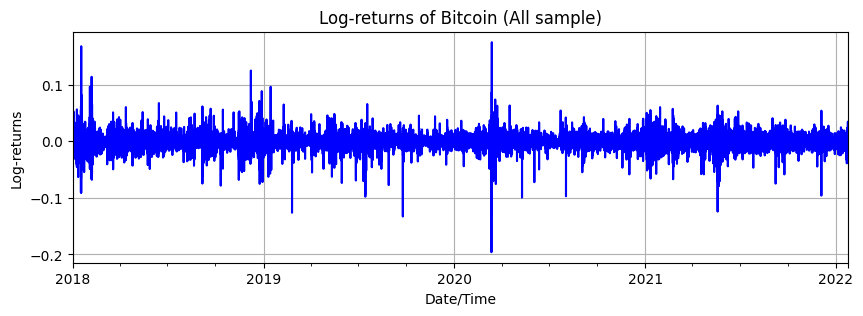

In [16]:
# Plotting log-returns
_ = df["LogReturns"].plot(figsize=(10, 3))
_ = plt.title("Log-returns of Bitcoin (All sample)")
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Log-returns")
_ = plt.grid()

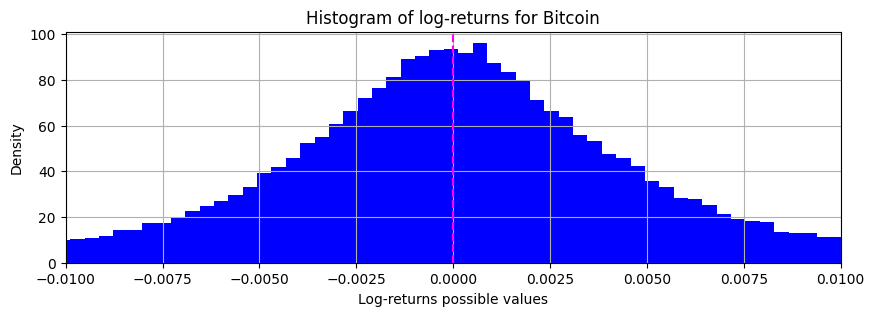

In [17]:
# Plotting log-returns
_ = df["LogReturns"].hist(bins=1000, density=True, figsize=(10, 3))
_ = plt.xlim([-0.01, 0.01])
_ = plt.title("Histogram of log-returns for Bitcoin")
_ = plt.xlabel("Log-returns possible values")
_ = plt.axvline(x = 0, color="magenta", ls="--")
_ = plt.ylabel("Density")

**Day-time range**

In [18]:
# Adding the daytime range for each line
try:
    df_t = [obs.hour for obs in list(df.index)]
    df["TimeRange"] = [Utils.get_daytime_range(time_) for time_ in df_t]
except KeyError:
    pass

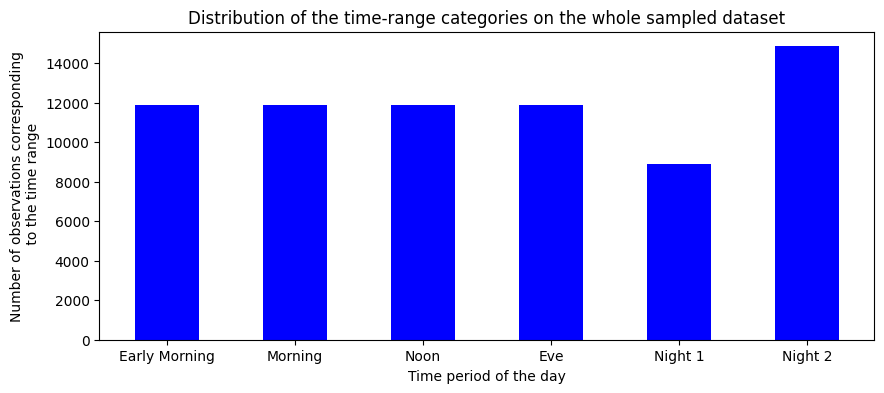

In [19]:
# Plotting the time-range distribution over all dataset
_ = plt.bar(x=list(range(6)), height= df["TimeRange"].value_counts().sort_index().to_numpy(), width=0.5)
_ = plt.xticks(ticks=list(range(6)), labels = ["Early Morning", "Morning", "Noon", "Eve", "Night 1", "Night 2"])
_ = plt.xlabel("Time period of the day")
_ = plt.ylabel("Number of observations corresponding\n to the time range")
_ = plt.title("Distribution of the time-range categories on the whole sampled dataset")

**Technical analysis indicators & & Moving averages**

In [20]:
# Computing Rolled average close price
df["Rolled_Avg_Close"] = df["Close"].rolling(window=10).mean()

# Computing correlation
df["Corr"] = df["Close"].rolling(window=10).corr(df["Rolled_Avg_Close"])

# Computing Open-Close indicator
df["Open-Close"] = df["Open"] - df["Close"].shift(1)

# Computing Open-Open indicator
df["Open-Open"] = df["Open"] - df["Open"].shift(1)

# Computing the RSI () indicator
df["RSI"] = Utils.rsi(df)

# Computing the Bollinger Bands (BB) indicators
upper_2sd, mid_2sd, lower_2sd = ta.BBANDS(df["Close"], 
                                          nbdevup=2,
                                          nbdevdn=2,
                                          timeperiod=20)
df["BBANDS_U"] = upper_2sd
df["BBANDS_M"] = mid_2sd
df["BBANDS_L"] = lower_2sd

# Computing SMA moving averages for various time windows
df["SMA_SLOW"] = ta.SMA(df["Close"], timeperiod=5)
df["SMA_MEDIUM"] = ta.SMA(df["Close"], timeperiod=10)
df["SMA_FAST"] = ta.SMA(df["Close"], timeperiod=15)

# TODO: Adding other technical analysis indicator
# Momentum
# Standard deviation
# ...

In [21]:
# Getting DataFrame shape
df_shape_before = df.shape[0]

# Dropping newly-created NaN values
df.dropna(inplace=True)

# Getting DataFrame shape
df_shape_after = df.shape[0]

# Getting number of deleted rows
#abs(df_shape_after - df_shape_before)

## Data visualization

In [22]:
# Correlation matrix
correlation_matrix = df.corr()
df.corr().style.background_gradient(cmap='autumn')
#df[df.columns.drop("Target")].corr().style.background_gradient(cmap='autumn')

,Count,Open,High,Low,Close,Volume,VWAP,LogReturns,TimeRange,Rolled_Avg_Close,Corr,Open-Close,Open-Open,RSI,BBANDS_U,BBANDS_M,BBANDS_L,SMA_SLOW,SMA_MEDIUM,SMA_FAST
Count,1.000000,0.552615,0.555482,0.547604,0.552275,0.596351,0.552216,-0.025468,-0.002474,0.554513,0.099852,0.002856,-0.088714,-0.027280,0.564938,0.556021,0.546515,0.553416,0.554513,0.555319
Open,0.552615,1.000000,0.999970,0.999942,0.999954,-0.013952,0.999983,-0.002323,0.000317,0.999911,0.008111,0.008101,0.005971,0.028076,0.999556,0.999783,0.999634,0.999973,0.999911,0.999848
High,0.555482,0.999970,1.000000,0.999909,0.999970,-0.011912,0.999982,0.000943,0.000339,0.999899,0.008459,0.008181,0.005368,0.029012,0.999613,0.999781,0.999569,0.999958,0.999899,0.999841
Low,0.547604,0.999942,0.999909,1.000000,0.999953,-0.017688,0.999963,0.001695,0.000291,0.999832,0.007601,0.008707,0.007536,0.030291,0.999378,0.999683,0.999615,0.999913,0.999832,0.999757
Close,0.552275,0.999954,0.999970,0.999953,1.000000,-0.014312,0.999986,0.004115,0.000289,0.999878,0.008130,0.008275,0.005787,0.030453,0.999520,0.999747,0.999598,0.999947,0.999878,0.999814
Volume,0.596351,-0.013952,-0.011912,-0.017688,-0.014312,1.000000,-0.014293,-0.055465,-0.020734,-0.012827,0.169293,0.001960,-0.064602,-0.026004,-0.006151,-0.011969,-0.018026,-0.013460,-0.012827,-0.012369
VWAP,0.552216,0.999983,0.999982,0.999963,0.999986,-0.014293,1.000000,0.001084,0.000319,0.999901,0.008101,0.008318,0.005842,0.029351,0.999541,0.999770,0.999623,0.999967,0.999901,0.999836
LogReturns,-0.025468,-0.002323,0.000943,0.001695,0.004115,-0.055465,0.001084,1.000000,-0.002744,-0.001436,-0.000861,0.056102,-0.009567,0.371018,-0.001643,-0.001645,-0.001646,-0.000965,-0.001436,-0.001550
TimeRange,-0.002474,0.000317,0.000339,0.000291,0.000289,-0.020734,0.000319,-0.002744,1.000000,0.000318,-0.005978,0.003287,-0.003004,0.024649,0.000421,0.000101,-0.000233,0.000351,0.000318,0.000198
Rolled_Avg_Close,0.554513,0.999911,0.999899,0.999832,0.999878,-0.012827,0.999901,-0.001436,0.000318,1.000000,0.008293,0.006511,-0.001430,0.022301,0.999720,0.999933,0.999769,0.999964,1.000000,0.999977


In [ ]:
# TODO

## Data pre-processing

**Construction of the target**

In [23]:
# Computation of the target
df["Target"] = np.where(df["Close"].shift(-1) > df["Close"], 1, 0)

**Conversion of the current dataset into a supervised learning dataset**

In [24]:
# Converting current dataset into a supervised learning dataset
LAGGED_SERIES = list(range(1, 20))
for lag in LAGGED_SERIES:
    df[f"Close (t - {lag})"] = df["Close"].shift(periods=lag)
    #df[f"Target (t - {lag})"] = df["Target"].shift(periods=lag)
    df[f"RSI (t - {lag})"] = df["RSI"].shift(periods=lag)
# Dropping newly-created NaN values
df.dropna(inplace=True)

**Truncate the dataset**

In [27]:
# Getting initial dataset (subset of time range)
eth_2018 = df["2018-01": "2018-04"]

In [29]:
eth_2018.head(3)

,Count,Open,High,Low,Close,Volume,VWAP,LogReturns,TimeRange,Rolled_Avg_Close,...,Close (t - 15),RSI (t - 15),Close (t - 16),RSI (t - 16),Close (t - 17),RSI (t - 17),Close (t - 18),RSI (t - 18),Close (t - 19),RSI (t - 19)
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 19:00:00,117.5,742.6575,756.95,737.39,746.3300,146.537221,744.037472,0.005512,3,744.34125,...,745.610000,48.449986,740.6125,42.191146,757.3850,66.624809,753.9725,62.665749,751.8425,60.000272
2018-01-01 19:30:00,90.5,746.1125,764.66,740.22,749.6025,174.069024,747.913453,0.004375,3,744.97025,...,742.162500,44.737379,745.6100,48.449986,740.6125,42.191146,757.3850,66.624809,753.9725,62.665749
2018-01-01 20:00:00,121.0,749.5925,763.88,744.17,751.6350,238.532394,751.465240,0.002708,3,745.01600,...,746.323333,49.886936,742.1625,44.737379,745.6100,48.449986,740.6125,42.191146,757.3850,66.624809


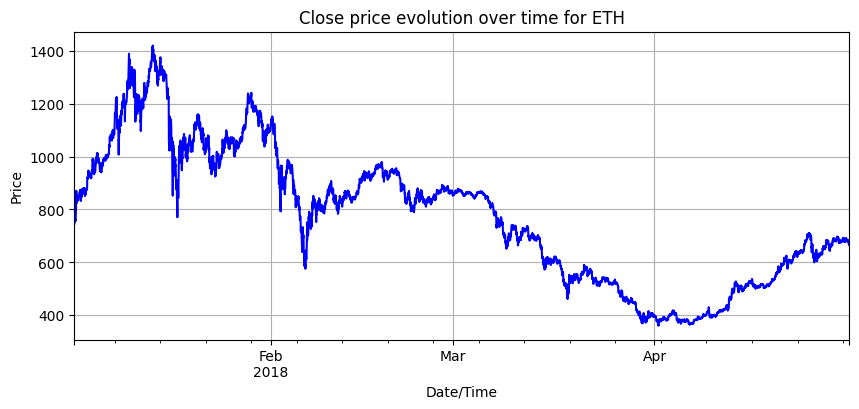

In [30]:
# Plotting OHLC time series
_ = eth_2018["Close"].plot()
_ = plt.grid()
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Price")
_ = plt.title("Close price evolution over time for ETH")

In [31]:
# Getting DataFrame shape
nb_obs, nb_cols = eth_2018.shape
print(f"Number of 30-min bins:\t {nb_obs}\nNumber of columns:\t {nb_cols}")

Number of 30-min bins:	 5722
Number of columns:	 59


**Definition of the model (parameters & split)**

In [33]:
# TODO

**Fitting & Predictions (using Incremental Learning)**

In [52]:
# Test on WF

# Splitting X/Y
X = eth_2018.copy() # X as a deep copy for security reason
Y = X.pop("Target")

# Defining the number of train points and number of records
n_train = 2_000
n_records = 2_400 #len(btc_2018)//2 # 200

# Model name (on-disk storage)
MODEL_NAME = f"../out/models/model_{0}"

# Horizon lags
HORIZON_LAGS = {
    "future": 10, # 15
    "past": n_train - int(n_train*0.4) # None
}

# Metrics
METRICS = {
    "train_size": {}, # Shape of the train set
    "test_size": {}, # Shape of the test set
    "exec_time": {}, # Execution (fitting + prediction) time
    "model_size": {} # File size of the on-disk model
}

# Predictions dataframes
preds_cols = ["ts"] + [str(i) for i in range(1, HORIZON_LAGS["future"] + 1)] + ["conf_mat"] + ["report"]
preds = pd.DataFrame(columns=preds_cols)

model = xgboost.XGBClassifier()

# Looping over each time t
for k, i in enumerate((pbar := tqdm.tqdm_notebook(range(n_train, n_records), colour="red"))):
    #print(k, "--", i)
    
    # Train/test split for X
    X_train = X.iloc[i - HORIZON_LAGS["past"]: i] # X.iloc[0: i]
    X_test = X.iloc[i: i + HORIZON_LAGS["future"]]
    
    # Getting the current datetime
    dt_now = list(X_train.index)[-1]
    
    # Defining the scaler pre-processor
    scaler = MinMaxScaler() # StandardScaler()
    
    # Scaling X_train
    X_train_scaled = scaler.fit_transform(X_train)
    # - None: XGBoost model fitting with X_train_scaled & Y_train
    # - X_test_scaled: Scaling of X_test using this scaler with input as X_test
    # - Y_pred: XGBoost model prediction with input X_test_scaled
    
    # Saving lengths
    METRICS["train_size"][dt_now] = len(X_train)
    METRICS["test_size"][dt_now] = len(X_test)

    # Train/test split for Y
    Y_train = Y.iloc[i - HORIZON_LAGS["past"]: i] # Y.iloc[0: i]
    Y_test = Y.iloc[i: i + HORIZON_LAGS["future"]]
    
    # Timing the fitting & prediction operations
    start_time = time.time()
    
    # Model name (on-disk storage) ==> Use the k-th counter to track iterations on MODEL_NAME to re-use fit
    MODEL_NAME = f"../out/models/model_289"
    
    # Importing the corresponding model for this iteration
    model.load_model(MODEL_NAME)
    
    # Scaling the X_test dataset with the scaler trained on X_train
    X_test_scaled = scaler.transform(X_test)
    
    # Converting X_test to a DMatrix (necessary for XGBoost)
    X_test_DMatrix = xgboost.DMatrix(data=X_test)
    
    # Predicting the HORIZON_LAGS["future"] market movements from dt_now
    Y_pred = model.predict(X=X_test) # or X_test_scaled
    #print(Y_pred)
    
    METRICS["model_size"][dt_now] = os.path.getsize(MODEL_NAME)/1e6
    
    # Storing the duration time for fitting step
    dur_time = time.time() - start_time
    METRICS["exec_time"][dt_now] = dur_time
    #print(f"Exec. time: {dur_time:.3f}s")
    pbar.set_description(f"#{k} - Current time: {dt_now}\t\t | Exec. time: {dur_time:.3f}s | FITTING")

    # Computing the confusion matrix
    conf_mat = confusion_matrix(y_true=list(Y_test.values), y_pred=list(Y_pred))
    
    # Getting classification report
    clf_report = classification_report(y_true=Y_test, y_pred=Y_pred, output_dict=True)
    
    # Appending the predictions
    preds = preds.append(pd.DataFrame([[dt_now] + list(Y_pred) + [conf_mat] + [clf_report]], columns=preds_cols), ignore_index=True)
    
    #print(train.shape, test.shape)

# Setting the timestamp as index column
try:
    preds.set_index("ts", inplace=True)
except KeyError:
    pass

  0%|          | 0/400 [00:00<?, ?it/s]

In [54]:
preds

,1,2,3,4,5,6,7,8,9,10,conf_mat,report
ts,,,,,,,,,,,,
2018-02-12 10:30:00,0,1,1,0,0,0,0,0,1,0,"[[5, 0], [2, 3]]","{'0': {'precision': 0.7142857142857143, 'recal..."
2018-02-12 11:00:00,1,1,0,0,0,0,0,1,0,0,"[[5, 0], [2, 3]]","{'0': {'precision': 0.7142857142857143, 'recal..."
2018-02-12 11:30:00,1,0,0,0,0,0,1,0,0,0,"[[5, 0], [3, 2]]","{'0': {'precision': 0.625, 'recall': 1.0, 'f1-..."
2018-02-12 12:00:00,0,0,0,0,0,1,0,0,0,1,"[[5, 0], [3, 2]]","{'0': {'precision': 0.625, 'recall': 1.0, 'f1-..."
2018-02-12 12:30:00,0,0,0,0,1,0,0,0,1,0,"[[5, 0], [3, 2]]","{'0': {'precision': 0.625, 'recall': 1.0, 'f1-..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-20 16:00:00,0,1,0,0,1,0,0,0,0,1,"[[6, 3], [1, 0]]","{'0': {'precision': 0.8571428571428571, 'recal..."
2018-02-20 16:30:00,1,0,0,1,0,0,0,0,1,0,"[[7, 3], [0, 0]]","{'0': {'precision': 1.0, 'recall': 0.7, 'f1-sc..."
2018-02-20 17:00:00,0,0,1,0,0,0,0,1,0,1,"[[7, 3], [0, 0]]","{'0': {'precision': 1.0, 'recall': 0.7, 'f1-sc..."
